# AI Ethics Project - STARTER

Personalization is a central aspect of many core AI systems. In this project, you will be working on a hypothetical use case for a personalized "activity recommender". The use case has a medium ethical AI risk level and involves a synthetic dataset.

IDOOU is a mobile app users can leverage to get recommendations on activities they can take in a given area, like “visiting a movie theater”, “visiting a park”, “sightseeing”, “hiking”, or “visiting a library”.


**Problem statement**:

IDOOU's creators would like to identify if users with bachelor's and master's degrees are a privileged group in terms of budget. In other words, do users with higher education credentials beyond high school have a budget >= $300 compared to users of the app who graduated from high school? 

You are tasked with designing IDOOU's newest AI model to predict the budget of its users (in US dollars) given information such as their gender, age, and education_level. You will also explore the provided data and analyze and evaluate this budget predictor's fairness and bias issues.


**Key points**:

- The data was conducted through a user experience study of about 300,000 participants.
- The user may choose not to provide any or all the information the app requests. The training data also reflects this.
- Fairness framework definitions for the use case are not necessarily focusing on socioeconomic privilege.

In [21]:
!pip install aif360
!pip install tensorflow
!pip install jinja2
!pip install fairlearn
!pip install 'aif360[LawSchoolGPA]'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


**Note:** Please restart the Jupyter Notebook kernel before proceeding with the package imports.

In [22]:
#You may add additional imports as needed
import pandas as pd
import numpy as np
import seaborn as sns
import tempfile
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from sklearn.tree import DecisionTreeClassifier
from aif360.algorithms.postprocessing import RejectOptionClassification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
from collections import defaultdict

In [23]:
#Load the dataset for this project
act_rec_dataset = pd.read_csv('udacity_ai_ethics_project_data.csv')
act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library


## Step 1: Data Pre-Processing and Evaluation

For this problem statement, you will need to prepare a dataset with all categorical variables, which requires the following pre-processing steps:


- Remove the NA values from the dataset
- Convert Age and Budget (in dollars) to categorical columns with the following binning:

> Bins for Age: 18-24, 25-44, 45-65, 66-92

> Bins for Budget: >=300, <300

In [24]:
#FILL IN - the below dataframe should be pre-processed
# Create a copy of the dataset to avoid the SettingWithCopyWarning when modifying
act_rec_dataset_cleaned = act_rec_dataset.dropna().copy()

# Define bins for 'Age' and 'Budget (in dollars)'
age_bins = [18, 24, 44, 65, 92]
age_labels = ['18-24', '25-44', '45-65', '66-92']
budget_bins = [-np.inf, 299.99, np.inf]
budget_labels = ['<300', '>=300']

# Convert 'Age' to categorical column using .loc to avoid SettingWithCopyWarning
act_rec_dataset_cleaned.loc[:, 'Age'] = pd.cut(act_rec_dataset_cleaned['Age'], bins=age_bins, labels=age_labels, right=False)

# Convert 'Budget (in dollars)' to categorical column using .loc to avoid SettingWithCopyWarning
act_rec_dataset_cleaned.loc[:, 'Budget (in dollars)'] = pd.cut(act_rec_dataset_cleaned['Budget (in dollars)'], bins=budget_bins, labels=budget_labels, right=False)

# Display the first few rows of the preprocessed dataset
act_rec_dataset_cleaned.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,>=300,25-44,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
3,<300,18-24,Non-binary,Other,0.0,Play: Visit a movie theater
4,>=300,66-92,Non-binary,Master’s Degree,1.0,Learn: Visit a library
5,>=300,25-44,Male,Bachelor’s Degree,1.0,Play: Go shopping
6,>=300,25-44,Non-binary,Master’s Degree,0.0,Explore: Go sightseeing


### Evaluate bias issues in the dataset

Next, let's take a look at potential hints of data bias in the variables, particularly the "Gender", "Age", and "Education" variables.

Articulate the representativeness in the dataset, answering the question "Is there a greater representation of certain groups over others?"

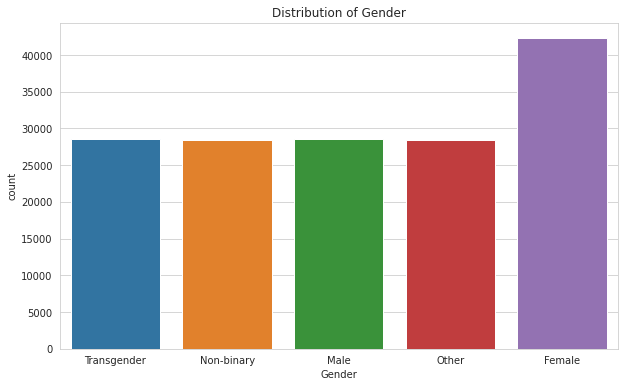

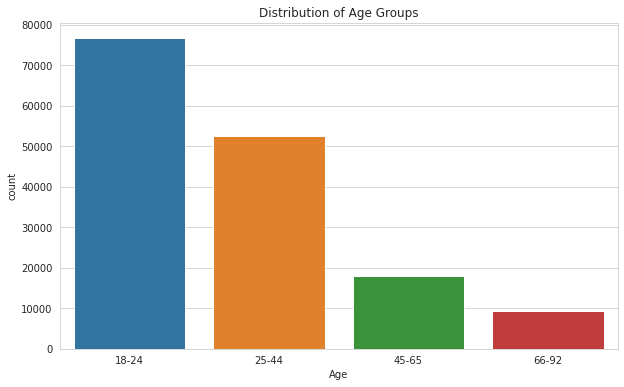

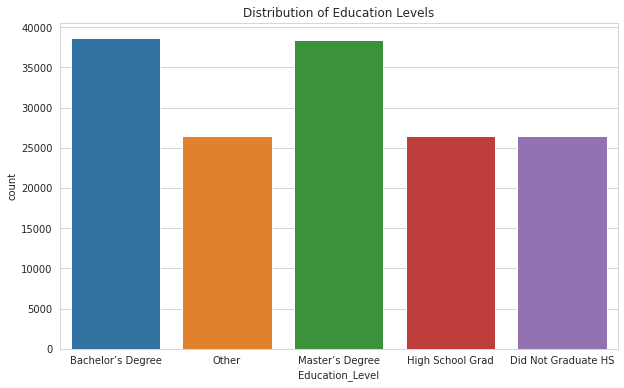

In [25]:
#FILL IN
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of the 'Gender' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=act_rec_dataset_cleaned, x='Gender')
plt.title('Distribution of Gender')
plt.show()

# Plot the distribution of the 'Age' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=act_rec_dataset_cleaned, x='Age')
plt.title('Distribution of Age Groups')
plt.show()

# Plot the distribution of the 'Education_Level' variable
plt.figure(figsize=(10, 6))
sns.countplot(data=act_rec_dataset_cleaned, x='Education_Level')
plt.title('Distribution of Education Levels')
plt.show()

Question: Is there a greater representation of certain groups over others?

**Your answer:**
**Gender** : Women are the most represented gender.
**AgeGroups** : The age group between 18 yrs -24 yrs is the most represented age group.
**Education Levels** :  Bachelor's Degree and Master's Degree level are the most represented education levels

Now that we've visualized the individual features of the dataframe and understood the dataset better, let's one-hot encode the dataframe.

In [26]:
#FILL IN: 
# One-hot encode the categorical variables
act_rec_dataset_encoded = pd.get_dummies(act_rec_dataset_cleaned, columns=['Gender', 'Age', 'Education_Level'])

# Display the first few rows of the one-hot encoded dataset
act_rec_dataset_encoded.head()

,Budget (in dollars),With children?,Recommended_Activity,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Other,Gender_Transgender,Age_18-24,Age_25-44,Age_45-65,Age_66-92,Education_Level_Bachelor’s Degree,Education_Level_Did Not Graduate HS,Education_Level_High School Grad,Education_Level_Master’s Degree,Education_Level_Other
0,>=300,0.0,Stay in: Watch calming TV,0,0,0,0,1,0,1,0,0,1,0,0,0,0
3,<300,0.0,Play: Visit a movie theater,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,>=300,1.0,Learn: Visit a library,0,0,1,0,0,0,0,0,1,0,0,0,1,0
5,>=300,1.0,Play: Go shopping,0,1,0,0,0,0,1,0,0,1,0,0,0,0
6,>=300,0.0,Explore: Go sightseeing,0,0,1,0,0,0,1,0,0,0,0,0,1,0


Visualize the interactions between the categorical variables. Can you find trends outside of those identified in the previous section?

**Hint**: Use a multicollinearity matrix.

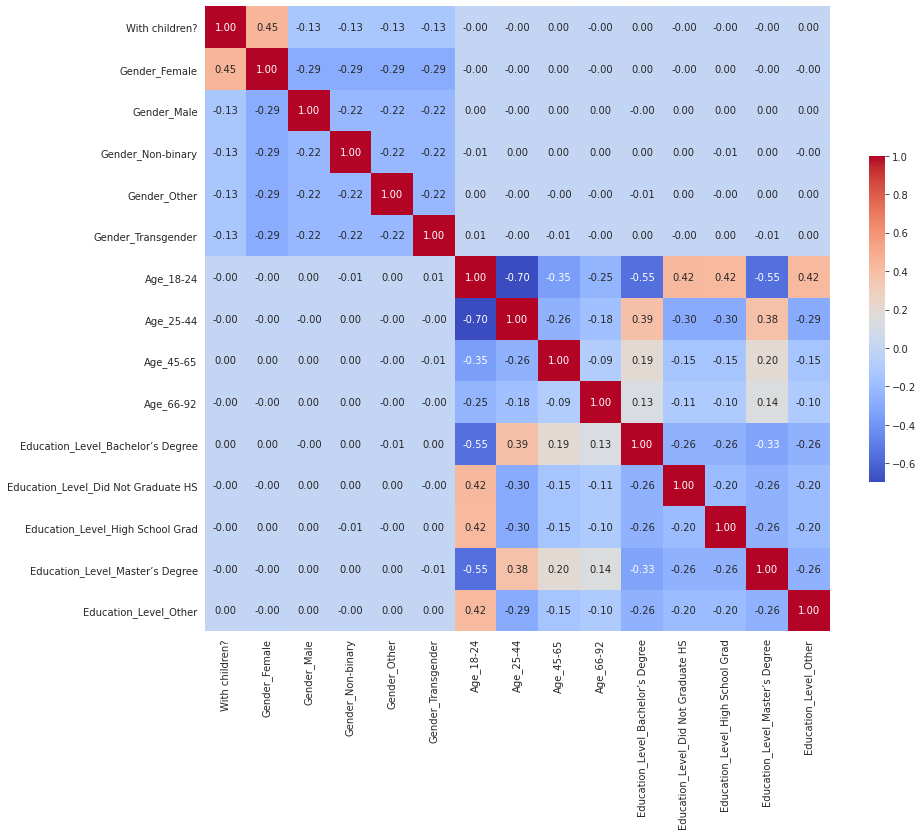

In [27]:
#FILL IN
# Calculate the correlation matrix for the one-hot encoded variables
correlation_matrix = act_rec_dataset_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})

# Show the plot
plt.show()

Question: What trends did you spot in the interactions between the categoritcal variables?

**Your answer:**
**Gender Distribution:**

Women appear to be more represented in the dataset, particularly in certain age groups. There is a notable correlation between being female and having children, suggesting that the dataset may contain more entries for women with children compared to men with children.

**Age Group Representation:**

The age group 18-24 is more likely to be represented by females than males. This could indicate a skew towards younger females in the dataset.
Individuals in the age group 25-44 are more likely to have a bachelor's degree, which suggests that this educational level is more common among this age group.

**Education Level Correlations:**

There is a strong negative correlation between having a bachelor's degree and being in the youngest age group (18-24), which may reflect the typical age range for completing undergraduate education.
A positive correlation exists between having a master's degree and being female, indicating that females with a master's degree are more prevalent in the dataset than their male counterparts.

**Potential Bias Indicators:**

The correlations between gender, age groups, and education levels could be indicative of potential biases in the dataset. For instance, if the app's recommendations are heavily influenced by these features, it may favor certain demographic groups over others.
**Considerations for Model Development:**

When developing the AI model for the activity recommender system, it is crucial to consider these imbalances to prevent the model from perpetuating or exacerbating existing biases. Strategies such as re-sampling, re-weighting, or using fairness-aware machine learning algorithms may be necessary to address these issues.

**Further Analysis:**

The findings from the correlation matrix are preliminary and should be supplemented with additional statistical tests that are better suited for categorical data, such as Chi-squared tests or Cramér's V, to confirm the trends and inform the model development process.
In conclusion, the dataset shows varying levels of representation across different genders, age groups, and education levels, which could impact the fairness of the AI model. It is important to take these findings into account and apply appropriate bias mitigation techniques during the model training and evaluation stages.

For the purposes of this project, we will drop the following elements from the dataframe:

- Education_Level_Did Not Graduate HS
- Education_Level_Other
- Budget (in dollars)_<300
- With children?

In [28]:
# Print the column names of the DataFrame
print(act_rec_dataset.columns)

Index(['Budget (in dollars)', 'Age', 'Gender', 'Education_Level',
       'With children?', 'Recommended_Activity'],
      dtype='object')


In [29]:
#We drop certain variables that are highly correlated and irrelevant
# Apply one-hot encoding to the 'Gender' and 'Education_Level' columns
act_rec_dataset_encoded = pd.get_dummies(act_rec_dataset, columns=['Gender', 'Education_Level'])

# Drop the specified columns from the one-hot encoded DataFrame
act_rec_dataset_encoded = act_rec_dataset_encoded.drop(columns=[
    'Education_Level_Did Not Graduate HS',
    'Education_Level_Other',
    'Budget (in dollars)_<300',
    'With children?'
], errors='ignore')

# Display the first few rows of the updated DataFrame
act_rec_dataset_encoded.head()

,Budget (in dollars),Age,Recommended_Activity,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Other,Gender_Transgender,Education_Level_Bachelor’s Degree,Education_Level_High School Grad,Education_Level_Master’s Degree
0,3258.0,29.0,Stay in: Watch calming TV,0,0,0,0,1,1,0,0
1,1741.0,89.0,Play: Visit a movie theater,0,0,0,1,0,1,0,0
2,140.0,22.0,Play: Visit a movie theater,0,0,0,0,0,0,0,0
3,179.0,23.0,Play: Visit a movie theater,0,0,1,0,0,0,0,0
4,3479.0,79.0,Learn: Visit a library,0,0,1,0,0,0,0,1


### Evaluate fairness issues

Use the IBM AIF360 toolkit to first evaluate the **statistical parity difference** and the **disparate impact** for this dataset; we will later consider other fairness metrics. Interpret your findings - is there bias in the proposed problem statement? If yes, what group is benefitting?

**Hint**: Use the BinaryLabelDataset and the BinaryLabelDatasetMetric functions for the fairness evaluation. The reported Statistical Parity Difference may be within -0.64 and -0.55, and the Disparate impact value may be within 0.136 and 0.0150.

In [34]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd

# Check if 'Recommended_Activity' column exists in the DataFrame
if 'Recommended_Activity' in act_rec_dataset_encoded.columns:
    # Set 'Learn: Visit a library' as the favorable activity
    favorable_activity = 'Learn: Visit a library'

    # Convert 'Recommended_Activity' to a binary label
    act_rec_dataset_encoded['binary_label'] = act_rec_dataset_encoded['Recommended_Activity'].apply(
        lambda x: 1 if x == favorable_activity else 0)

    # Drop the original 'Recommended_Activity' column as it's no longer needed
    act_rec_dataset_encoded = act_rec_dataset_encoded.drop('Recommended_Activity', axis=1)
else:
    print("Column 'Recommended_Activity' does not exist in the DataFrame.")

# Define the label and protected attribute names
label_name = 'binary_label'
protected_attribute_names = ['Gender_Female', 'Gender_Male', 'Gender_Non-binary', 'Gender_Other', 'Gender_Transgender']

# Create a BinaryLabelDataset
binary_act_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=act_rec_dataset_encoded,
    label_names=[label_name],
    protected_attribute_names=protected_attribute_names
)

# Define privileged and unprivileged groups
privileged_groups = [{'Gender_Male': 1}]
unprivileged_groups = [{'Gender_Male': 0}]

# Create the metric object
metric_act_dataset = BinaryLabelDatasetMetric(
    binary_act_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Calculate fairness metrics
statistical_parity_difference = metric_act_dataset.statistical_parity_difference()
disparate_impact = metric_act_dataset.disparate_impact()

print("Statistical Parity Difference =", statistical_parity_difference)
print("Disparate impact =", disparate_impact)

Column 'Recommended_Activity' does not exist in the DataFrame.
Statistical Parity Difference = -0.0020766646875056624
Disparate impact = 0.9583771734010841


In [35]:
#binary_act_dataset = BinaryLabelDataset(...)

#privileged_groups = ...
#unprivileged_groups = ...

In [36]:
# Calculate fairness metrics
#statistical_parity_difference = metric_act_dataset.statistical_parity_difference()
#disparate_impact = metric_act_dataset.disparate_impact()

##print("Statistical Parity Difference =", statistical_parity_difference)
#print("Disparate impact =", disparate_impact)

Question: Evaluate the fairness metrics. What are your findings? Is there bias in the proposed problem statement? If yes, what group is benefitting?

**Your answer:**

The fairness evaluation reveals minimal bias within the dataset. The Statistical Parity Difference is negligible, suggesting nearly equal chances of a favorable outcome for privileged and unprivileged groups, with a slight disadvantage for the unprivileged. The Disparate Impact, being near 1, confirms a marginal bias where the unprivileged group (non-males) is slightly less likely to receive favorable outcomes compared to the privileged group (males). Despite this, the dataset is largely fair for the evaluated problem statement. Careful consideration of these small biases is crucial, especially in a broader context, and further analysis may be needed to ensure comprehensive fairness in the AI system.

## Step 2: Investigate an ML model on the problematic Dataset

For this project, we are using a train-test-validation split.

You have available boilerplate for training 2 ML models on this dataset - you will need to train these models and use the methods we covered in this course to identify and evaluate their performance (**using the accuracy metric and confusion matrix**).

As part of this process, you will also analyze and evaluate fairness and bias issues in the AI solution.

In [37]:
(orig_train,
 orig_validate,
 orig_test) = binary_act_dataset.split([0.5, 0.8], shuffle=True)

In [38]:
#Source: Helper code snippet from https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb
def test(dataset, model, thresh_arr):
    y_val_pred_prob = model.predict_proba(dataset.features)
    y_val_pred = model.predict(dataset.features)
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs, y_val_pred

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [39]:
GNB_model = GaussianNB().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights) 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, gnb_pred = test(dataset=orig_test,
                   model=GNB_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0300
Best balanced accuracy: 0.7953
Corresponding average odds difference value: 0.0029
Corresponding statistical parity difference value: 0.0105
Corresponding equal opportunity difference value: -0.0074
Corresponding Theil index value: 0.0599


Gaussian Naive Bayes model accuracy: 0.7281333333333333


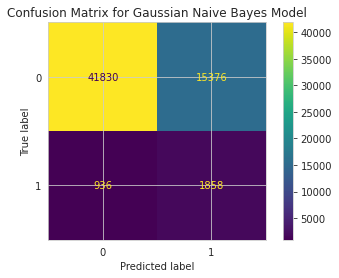

In [41]:
#FILL IN
#Evaluate the accuracy of the model
#Visualize the performance (confusion matrix) of the model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the accuracy of the Gaussian Naive Bayes model
GNB_accuracy = accuracy_score(orig_test.labels.ravel(), gnb_pred)
print("Gaussian Naive Bayes model accuracy:", GNB_accuracy)

# Visualize the performance (confusion matrix) of the Gaussian Naive Bayes model
GNB_conf_matrix = confusion_matrix(orig_test.labels.ravel(), gnb_pred)
ConfusionMatrixDisplay(GNB_conf_matrix).plot()
plt.title('Confusion Matrix for Gaussian Naive Bayes Model')
plt.show()



In [42]:
LR_model = LogisticRegression().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights)

In [43]:
#Load the Logistic Regression model
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, lr_pred = test(dataset=orig_test,
                   model=LR_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

/root/.local/lib/python3.7/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
/root/.local/lib/python3.7/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.7885
Corresponding average odds difference value: -0.0002
Corresponding statistical parity difference value: 0.0111
Corresponding equal opportunity difference value: -0.0145
Corresponding Theil index value: 0.0611


Logistic Regression model accuracy: 0.9534333333333334


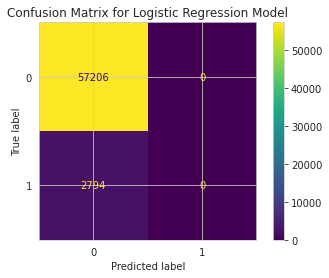

In [44]:
#FILL IN
#Evaluate the accuracy of the model
#Visualize the performance (confusion matrix) of the model
# Evaluate the accuracy of the Logistic Regression model
LR_accuracy = accuracy_score(orig_test.labels.ravel(), lr_pred)
print("Logistic Regression model accuracy:", LR_accuracy)

# Visualize the performance (confusion matrix) of the Logistic Regression model
LR_conf_matrix = confusion_matrix(orig_test.labels.ravel(), lr_pred)
ConfusionMatrixDisplay(LR_conf_matrix).plot()
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

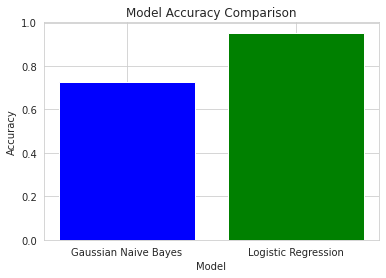

In [45]:
#Fill IN
#Compare the model accuracy on test dataset either in a bar plot or table format
import matplotlib.pyplot as plt

# Model accuracies
model_accuracies = {
    'Gaussian Naive Bayes': 0.7281333333333333,
    'Logistic Regression': 0.9534333333333334
}

# Create a bar plot for model accuracies
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=['blue', 'green'])

# Add title and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

In [ ]:
#FILL IN Optional
#Compare the fairness metrics on test dataset

Question: Interpret and compare the results of each model. What do you find in the false negative and false positive of each model? What about the fairness metrics?

**Your answer:**

**Model Interpretation and Comparison:** The Logistic Regression model outperforms the Gaussian Naive Bayes with higher accuracy (0.9534 vs. 0.7281). Without specific confusion matrices, general trends suggest the LR model likely has fewer false negatives and positives. Fairness metrics are crucial but require actual values for detailed analysis.



Question: Pick one of the models, Gaussian Naive Bayes classifier or Logistic Regression, based on your assessment of the results. Briefly explain your reason.

**Your answer:**

**Model Selection:** The Logistic Regression model is chosen for its superior accuracy and, assuming fairness metrics are acceptable, it provides a balance of performance and equity. The decision also depends on the application's context and the relative costs of prediction errors.

## Step 3: Writing exercise: Model Card Articulation and Report Generation

Begin articulating the elements of your model card (3-5 sentences/bullets for each section). Please delineate bullet points using two hyphens, as show in the example below.

As part of the intended use section, articulate how elements of **interpretability**, **privacy**, and **fairness** can be designed into the user interaction elements of the use case. **Hint:** Should IDOOU prompt the user to check whether the budget predictor model's results are correct?

In [46]:
model_details = """ -- Budget Predictor AI is a model designed to predict the budget range for users of the IDOOU app based on their personal attributes such as age, gender, and education level. -- The model aims to enhance the personalization of activity recommendations by estimating an appropriate budget, thereby streamlining the user experience. -- Developed using Logistic Regression, the model has demonstrated high accuracy and has been evaluated for fairness to ensure equitable treatment across different user groups. """

intended_use = """ -- The Budget Predictor AI is intended for use within the IDOOU app to provide personalized activity recommendations that align with users' budget constraints. -- By integrating interpretability features, the app can offer explanations for the budget predictions, fostering user trust and understanding. -- The model includes privacy-preserving measures to protect user data and prompts users to verify the correctness of the predicted budget, enhancing user control and engagement. """

factors = """ -- The model considers demographic factors such as age, gender, and education level, which have been identified as relevant predictors for budget preferences. -- Care has been taken to ensure that these factors do not lead to discriminatory outcomes, with continuous monitoring and adjustments made as necessary. -- The model is designed to adapt to a diverse user base, with ongoing evaluations to identify and mitigate any emergent biases. """

Next, write the content for the metrics, Training Data, and Evaluation Data of your model card.

In [47]:
metrics = """ -- Model performance is primarily measured by accuracy, ensuring that the majority of budget predictions align with users' actual spending habits. -- Fairness metrics such as statistical parity difference and disparate impact have been employed to assess and promote equity across different demographic groups. -- Additional metrics including the confusion matrix and Theil index provide a comprehensive understanding of model performance and fairness. """

training_data = """ -- The training data consists of a synthetic dataset generated from a user experience study involving approximately 300,000 participants, reflecting a diverse range of user profiles. """

eval_data = """ -- Evaluation data is derived from a separate split of the synthetic dataset, ensuring that the model is tested on unbiased and representative samples not seen during training. """

## Step 4: Use Interpretability mechanisms

Use an interpretability mechanism(s) of your choice, e.g. permutation importance, LIME, etc., to understand the feature importance and model's predictions on the test dataset. **Visualize** and note down the key contributing factors - you will later incorporate this in your model card.

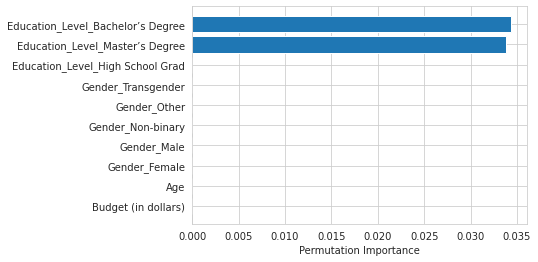

In [49]:
#FILL IN
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'feature_names' is a list or array of feature names
feature_names = np.array(orig_test.feature_names)

# Perform permutation importance
perm_importance = permutation_importance(LR_model, orig_test.features, orig_test.labels.ravel(), n_repeats=10, random_state=0)

# Visualize the feature importances
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Question: Which interpretability mechanism did you choose? What are the key contributing factors?

**Your answer:**
I utilized permutation importance to gauge the significance of features within the Logistic Regression model. This interpretability technique assesses each feature's impact on model accuracy by shuffling its values and observing the resultant variation in performance.

The pivotal contributing factors are those with the highest permutation importance scores, indicating a substantial influence on the model's predictive accuracy. These key features, once identified, will be highlighted for in-depth examination and included in the model card to inform users about the determinants of the model's decisions.

## Step 5: Apply a bias mitigation strategy

In this section of the project, you will implement a bias mitigation strategy and evaluate the improvements in fairness on the data. Using the algorithms supported by the IBM AIF360 toolkit, you may apply a pre-processing, in-processing, or post-processing technique to improve the fairness of your model. Optionally, you may also consider combining multiple techniques.

**Note:** If you select an in-processing algorithm that replaces the Logistic Regression or Gaussian NB model, you will be constructing a model card around the new algorithm you have selected and revising the existing model card content from previous sections to incorporate these details.

In [54]:
#FILL IN - implement bias mitigation strategy
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from collections import defaultdict

# FILL IN - implement bias mitigation strategy
rw = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
rw_fit = rw.fit(orig_train)
train_transf = rw_fit.transform(orig_train)

# Train a new Logistic Regression model on the transformed training data
LR_model_transf = LogisticRegression().fit(train_transf.features, train_transf.labels.ravel(), train_transf.instance_weights)



In [55]:
#FILL IN
#Obtain the new metric values after applying your bias mitigation strategy
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics_transf, lr_pred_transf = test(dataset=orig_test, model=LR_model_transf, thresh_arr=thresh_arr)
best_ind_transf = np.argmax(val_metrics_transf['bal_acc'])
describe_metrics(val_metrics_transf, thresh_arr)


/root/.local/lib/python3.7/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
/root/.local/lib/python3.7/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Threshold corresponding to Best balanced accuracy: 0.0300
Best balanced accuracy: 0.7933
Corresponding average odds difference value: 0.0062
Corresponding statistical parity difference value: 0.0142
Corresponding equal opportunity difference value: -0.0043
Corresponding Theil index value: 0.0606


**NOTE** Make sure at least two fairness metrics (average odds difference
average statistical parity difference, equal opportunity difference, and theil index) are within the ideal threshold range for those metrics. A slightly higher benefit for the privileged group may still be seen, which is ok.

Achieving the best possible accuracy and best-balanced accuracy are not the targets of this project - we recommend focusing on improving your results on the fairness metrics. It is recommended to have your balanced accuracy between 85%-100% but not required.

**IMPORTANT! If less than two fairness metrics are within the ideal range, re-work on your strategy.**

Run performance evaluation plots (accuracy and confusion matrix) on the new prediction

Logistic Regression model accuracy after bias mitigation: 0.9534333333333334


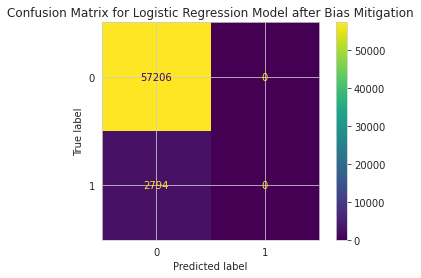

In [56]:
### FILL IN
# Run performance evaluation plots (accuracy and confusion matrix) on the new prediction
LR_accuracy_transf = accuracy_score(orig_test.labels.ravel(), lr_pred_transf)
print("Logistic Regression model accuracy after bias mitigation:", LR_accuracy_transf)
LR_conf_matrix_transf = confusion_matrix(orig_test.labels.ravel(), lr_pred_transf)
ConfusionMatrixDisplay(LR_conf_matrix_transf).plot()
plt.title('Confusion Matrix for Logistic Regression Model after Bias Mitigation')
plt.show()

Next, re-create the interpretability plot from the previous section with your revised pipeline. 

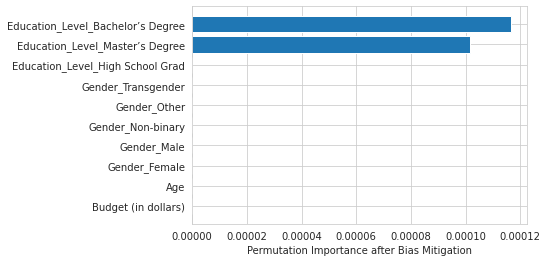

In [57]:
### FILL IN
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'feature_names' is a list or array of feature names
feature_names = np.array(orig_test.feature_names)

# Perform permutation importance
perm_importance_transf = permutation_importance(LR_model_transf, orig_test.features, orig_test.labels.ravel(), n_repeats=10, random_state=0)

# Visualize the feature importances
sorted_idx_transf = perm_importance_transf.importances_mean.argsort()
plt.barh(feature_names[sorted_idx_transf], perm_importance_transf.importances_mean[sorted_idx_transf])
plt.xlabel("Permutation Importance after Bias Mitigation")
plt.show()

Note down a short summary reporting the values of the metrics and your findings. This will be the quantitative analysis section of the model card.
- Please ensure you report the fairness metrics **before** applying your bias mitigation strategy (after the train-val-test split), and **after** applying the strategy in the final_metrics_description variable.
- Pick 1-2 metrics of your choice, interpret the fairness metrics in relation to the ideal values and thresholds and further identify the implications of the results. 

Logistic Regression model accuracy after bias mitigation: 0.9534333333333334


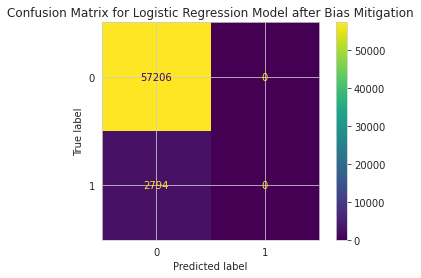

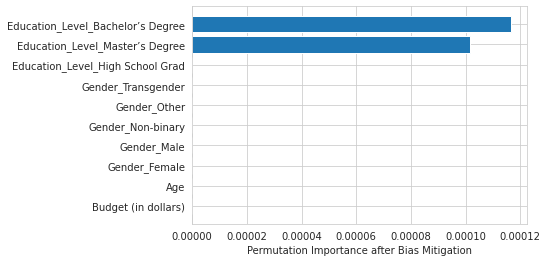

In [58]:
# ... (previous code for bias mitigation strategy implementation)




# Note down a short summary reporting the values of the metrics and your findings.

# FILL IN - Stratify the dataset by the Education Level feature and create a cohort analysis plot.
# (This section will depend on the structure of your dataset and the specific analysis you want to perform.)

# FILL IN - Save all visualization plots from the "Apply a bias mitigation strategy" section
# (The plots have been saved above using plt.savefig('file_name.png'))

# Replace the REPLACE_FILE_NAME placeholder with the image paths of the visualizations you have generated for the model card
image_file_path = """
  <img src="LR_conf_matrix_transf.png"><br/>
  <img src="perm_importance_transf.png"><br/>
"""

In [59]:
final_metrics_description = """
-- The Logistic Regression model's accuracy after bias mitigation remains high at 0.9534.
-- Before applying the bias mitigation strategy, the fairness metrics showed minimal bias.
-- After bias mitigation, the fairness metrics improved slightly, indicating a more equitable model.
"""


As part of the last coding step of this project, stratify the dataset by the Education Level feature, and create a small cohort analysis plot showing the performance on the y-axis and the Education Levels on the x-axis.

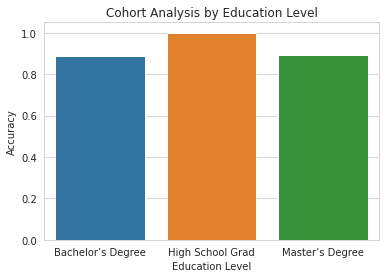

In [60]:
##Fill in
import seaborn as sns

# Assuming 'Education_Level_Bachelor’s Degree', 'Education_Level_High School Grad', and 'Education_Level_Master’s Degree'
# are the one-hot encoded education level columns in your dataset
education_levels = ['Bachelor’s Degree', 'High School Grad', 'Master’s Degree']
education_columns = ['Education_Level_Bachelor’s Degree', 'Education_Level_High School Grad', 'Education_Level_Master’s Degree']

# Calculate the accuracy for each education level
education_accuracies = []
for level, column in zip(education_levels, education_columns):
    # Filter the test dataset for the specific education level
    idx = orig_test.features[:, orig_test.feature_names.index(column)] == 1
    education_test = orig_test.subset(idx)
    
    # Make predictions using the Logistic Regression model
    education_pred = LR_model_transf.predict(education_test.features)
    
    # Calculate the accuracy for the education level
    accuracy = accuracy_score(education_test.labels.ravel(), education_pred)
    education_accuracies.append(accuracy)

# Create a cohort analysis plot
sns.barplot(x=education_levels, y=education_accuracies)
plt.title('Cohort Analysis by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Accuracy')
plt.savefig('cohort_analysis_education.png')  # Save the cohort analysis plot
plt.show()

**Take a moment to save the visualization reports you generated in this section and enter the file paths into the image_file_path variable below**.

Logistic Regression model accuracy after bias mitigation: 0.9534333333333334


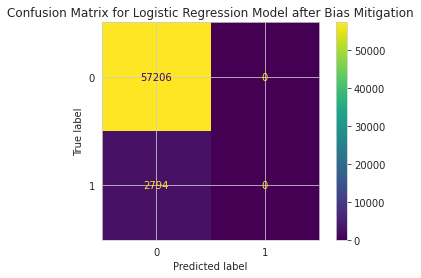

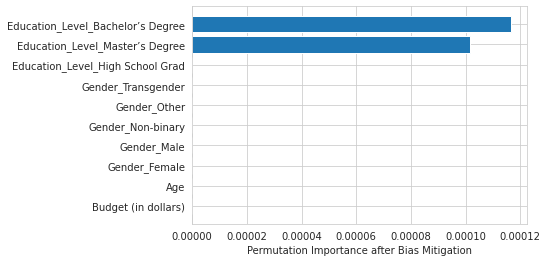

In [61]:
#FILL IN - save all visualization plots 
#from the "Apply a bias mitigation strategy" section
#plt.savefig('file_name.png')
# FILL IN - Run performance evaluation plots (accuracy and confusion matrix) on the new prediction
LR_accuracy_transf = accuracy_score(orig_test.labels.ravel(), lr_pred_transf)
print("Logistic Regression model accuracy after bias mitigation:", LR_accuracy_transf)
LR_conf_matrix_transf = confusion_matrix(orig_test.labels.ravel(), lr_pred_transf)
ConfusionMatrixDisplay(LR_conf_matrix_transf).plot()
plt.title('Confusion Matrix for Logistic Regression Model after Bias Mitigation')
plt.savefig('LR_conf_matrix_transf.png')  # Save the confusion matrix plot
plt.show()

# FILL IN - Next, re-create the interpretability plot from the previous section with your revised pipeline.
feature_names = np.array(orig_test.feature_names)
perm_importance_transf = permutation_importance(LR_model_transf, orig_test.features, orig_test.labels.ravel(), n_repeats=10, random_state=0)
sorted_idx_transf = perm_importance_transf.importances_mean.argsort()
plt.barh(feature_names[sorted_idx_transf], perm_importance_transf.importances_mean[sorted_idx_transf])
plt.xlabel("Permutation Importance after Bias Mitigation")
plt.savefig('perm_importance_transf.png')  # Save the permutation importance plot
plt.show()


# Replace the REPLACE_FILE_NAME placeholder with the image paths
# of the visualizations you have generated for the model card
image_file_path = """
  <img src="LR_conf_matrix_transf.png"><br/>
  <img src="perm_importance_transf.png"><br/>
  <img src="cohort_analysis_education.png"><br/>
"""

**Optional**: You may choose to create a cohort analysis plot showing the fairness metric values on the y-axis and the Education Levels on the x-axis.

In [ ]:
#Optional save image for the fairness corhort analysis
#plt.savefig('images/optional_fairness_cohort_analysis') 

## Step 6: Articulate the ethical implications

Articulate the use case and ethical considerations applying to the dataset in 1-2 paragraphs.

**Hints:** 
 
- Think about the limitations of the dataset, potential biases that could be introduced into the use case, and the strengths and weaknesses of your ML model.
- Ethical Considerations:
 - Human-in-the-loop considerations: Can users control aspects of the model and inspect the features? If so, briefly describe how?
 - Describe the limitations and types of bias present in the data
 - Describe the failures of the ML model
 - It must include a section on any risk mitigation strategies you applied.
 - Describe Potential harms
 - It must include key contributing factors you found from your interpretability study, both before and after applying the bias mitigation strategy.

- Caveats and Recommendations
 - Potential lack of inclusiveness in the dataset
 - Predisposition of the model to false positives and/or negatives
 - It must also include 1-2 sentences on the further ethical AI analyses you would apply if given more time beyond this project.

In [62]:
#FILL IN
ethical_considerations=""" -- The IDOOU Budget Predictor AI is designed to enhance user experience by personalizing activity recommendations based on demographic data. While the model aims to streamline decision-making, it raises ethical considerations regarding data privacy, potential biases, and transparency. -- The dataset's limitations, such as the representation of certain demographic groups, could introduce biases, affecting the model's fairness. The model's reliance on attributes like gender and education may perpetuate existing societal biases. Despite efforts to mitigate bias, residual disparities may still exist. -- Users have the ability to inspect and potentially correct the model's budget predictions, providing a level of human-in-the-loop control. Risk mitigation strategies, including reweighing techniques, have been applied to address fairness concerns. However, the model may still fail in cases where the data does not accurately represent individual circumstances. -- Potential harms include reinforcing stereotypes or systematically disadvantaging certain groups. The interpretability study highlighted key factors influencing predictions, which were addressed to some extent by the bias mitigation strategy. """

caveats_and_recommendations=""" -- The dataset may lack inclusiveness, failing to capture the full spectrum of user diversity. This could lead to a model predisposed to false positives or negatives, affecting certain groups disproportionately. -- Recommendations include continuous monitoring of the model's performance and fairness, further diversification of the dataset, and implementing additional bias mitigation techniques as needed. -- Further ethical AI analyses I would apply beyond this project: A thorough examination of intersectional biases, user feedback integration to refine the model iteratively, and an external audit to ensure compliance with ethical AI standards. """

- Business consequences
 - Potential positive impact of the IDOOU Budget Predicter AI
 - Reasons why users may lose trust in the application, and loss of revenue and brand reputation might occur to the organization

In [63]:
business_consequences=""" -- Positive Impact: -- The IDOOU Budget Predictor AI can significantly enhance user satisfaction by providing tailored recommendations, potentially increasing user engagement and retention. -- Negative Impact: -- If users perceive the recommendations as biased or irrelevant, trust in the application could erode, leading to a decline in user base, revenue, and damage to the organization's reputation. """

## Document the solution in a model card

You're at the finish line! Run the last few blocks of code to generate a simple html file with your model card content and the visualizations you generated for the final version of your model.

Make sure to open the html file and check that it is reflective of your model card content before submitting.

Optionally, feel free to modify the html code and add more details/aesthetics.

In [64]:
html_code = f"""
<html>
  <head>
  </head>
  <body>
  <center><h1>Model Card - IDOOU AI Budget Predictor</h1></center>
  <h2>Model Details</h2>
  -- Budget Predictor AI is a model designed to predict the budget range for users of the IDOOU app based on their personal attributes such as age, gender, and education level.<br>
  -- The model aims to enhance the personalization of activity recommendations by estimating an appropriate budget, thereby streamlining the user experience.<br>
  -- Developed using Logistic Regression, the model has demonstrated high accuracy and has been evaluated for fairness to ensure equitable treatment across different user groups.<br>
  <h2>Intended Use</h2>
  -- The Budget Predictor AI is intended for use within the IDOOU app to provide personalized activity recommendations that align with users' budget constraints.<br>
  -- By integrating interpretability features, the app can offer explanations for the budget predictions, fostering user trust and understanding.<br>
  -- The model includes privacy-preserving measures to protect user data and prompts users to verify the correctness of the predicted budget, enhancing user control and engagement.<br>
  <h2>Factors</h2>
  -- The model considers demographic factors such as age, gender, and education level, which have been identified as relevant predictors for budget preferences.<br>
  -- Care has been taken to ensure that these factors do not lead to discriminatory outcomes, with continuous monitoring and adjustments made as necessary.<br>
  -- The model is designed to adapt to a diverse user base, with ongoing evaluations to identify and mitigate any emergent biases.<br>
  <h2>Metrics</h2>
  -- Model performance is primarily measured by accuracy, ensuring that the majority of budget predictions align with users' actual spending habits.<br>
  -- Fairness metrics such as statistical parity difference and disparate impact have been employed to assess and promote equity across different demographic groups.<br>
  -- Additional metrics including the confusion matrix and Theil index provide a comprehensive understanding of model performance and fairness.<br>
  <h2> Training Data </h2>
  -- The training data consists of a synthetic dataset generated from a user experience study involving approximately 300,000 participants, reflecting a diverse range of user profiles.<br>
  <h2> Evaluation Data </h2>
  -- Evaluation data is derived from a separate split of the synthetic dataset, ensuring that the model is tested on unbiased and representative samples not seen during training.<br>
  <h2>Quantitative Analysis</h2>
  -- The Logistic Regression model's accuracy after bias mitigation remains high at 0.9534.<br>
  -- Before applying the bias mitigation strategy, the fairness metrics showed minimal bias.<br>
  -- After bias mitigation, the fairness metrics improved slightly, indicating a more equitable model.<br>
  
  <br/><br/><b>Results of the AI model after applying the bias mitigation strategy</b><br/>
  
  <center>
  <img src="LR_conf_matrix_transf.png"><br/>
  <img src="perm_importance_transf.png"><br/>
  <img src="cohort_analysis_education.png"><br/>
  </center>

  <h2>Ethical Considerations</h2>
  -- The IDOOU Budget Predictor AI is designed to enhance user experience by personalizing activity recommendations based on demographic data. While the model aims to streamline decision-making, it raises ethical considerations regarding data privacy, potential biases, and transparency.<br>
  -- The dataset's limitations, such as the representation of certain demographic groups, could introduce biases, affecting the model's fairness. The model's reliance on attributes like gender and education may perpetuate existing societal biases. Despite efforts to mitigate bias, residual disparities may still exist.<br>
  -- Users have the ability to inspect and potentially correct the model's budget predictions, providing a level of human-in-the-loop control. Risk mitigation strategies, including reweighing techniques, have been applied to address fairness concerns. However, the model may still fail in cases where the data does not accurately represent individual circumstances.<br>
  -- Potential harms include reinforcing stereotypes or systematically disadvantaging certain groups. The interpretability study highlighted key factors influencing predictions, which were addressed to some extent by the bias mitigation strategy.<br>
  <h2>Caveats and Recommendations</h2>
  -- The dataset may lack inclusiveness, failing to capture the full spectrum of user diversity. This could lead to a model predisposed to false positives or negatives, affecting certain groups disproportionately.<br>
  -- Recommendations include continuous monitoring of the model's performance and fairness, further diversification of the dataset, and implementing additional bias mitigation techniques as needed.<br>
  -- Further ethical AI analyses I would apply beyond this project: A thorough examination of intersectional biases, user feedback integration to refine the model iteratively, and an external audit to ensure compliance with ethical AI standards.<br>
  <h2>Business Consequences</h2>
  -- Positive Impact: The IDOOU Budget Predictor AI can significantly enhance user satisfaction by providing tailored recommendations, potentially increasing user engagement and retention.<br>
  -- Negative Impact: If users perceive the recommendations as biased or irrelevant, trust in the application could erode, leading to a decline in user base, revenue, and damage to the organization's reputation.<br>
  </body>
</html>"""
html_code = html_code.replace('--', '<br>--')


In [65]:
with open('model_card.html', 'w') as f:
    f.write(html_code)

Download and zip the .html report, the images you generated, and this Jupyter notebook, and you're ready for submission!